# 네이버 영화평 감성분석 - LSTM

In [1]:
!pip install Konlpy > /dev/null

In [3]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [4]:
# 네이버 영화 리뷰 데이터로 검색
train_df = pd.read_csv("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", sep='\t')
test_df = pd.read_csv("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", sep='\t')

In [5]:
print(train_df.shape, test_df.shape)
train_df.head(3)

(150000, 3) (50000, 3)


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0


### 1. 데이터 전처리

In [7]:
# Null 데이터 제거
train_df.dropna(how='any', inplace=True)
test_df.dropna(how='any', inplace=True)

# 중복데이터 제거
train_df.drop_duplicates(subset=['document'], inplace=True)
test_df.drop_duplicates(subset=['document'], inplace=True)

49157

### 2. 텍스트 전처리

In [8]:
# 한글 이외의 문자는 공백으로 처리하고 strip
train_df.document = train_df.document.str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣]', ' ').str.strip()
test_df.document = test_df.document.str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣]', ' ').str.strip()

# ''만 남은 데이터 -> np.nan 으로 대체한 후 제거
train_df.document.replace('', np.nan, inplace=True)
train_df.dropna(how='any', inplace=True)
test_df.document.replace('', np.nan, inplace=True)
test_df.dropna(how='any', inplace=True)

In [11]:
import os
if not os.path.exists('data'):
    os.mkdir('data')
train_df.to_csv('./data/naver_movie_train_전처리완료.tsv', sep='\t', index=False)
test_df.to_csv('./data/naver_movie_test_전처리완료.tsv', sep='\t', index=False)

### 3. 한글 형태소 분석

In [12]:
from konlpy.tag import Okt
okt = Okt()

In [13]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다','을','ㅋㅋ','ㅠㅠ','ㅎㅎ']

In [14]:
from tqdm.notebook import tqdm

X_train = []
for sentence in tqdm(train_df.document):
    morphs = okt.morphs(sentence, stem=True)
    tmp_X = [word for word in morphs if word not in stopwords]
    X_train.append(tmp_X)

  0%|          | 0/145393 [00:00<?, ?it/s]

In [15]:
X_train[:3]

[['아', '더빙', '진짜', '짜증나다', '목소리'],
 ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍다', '않다'],
 ['너', '무재', '밓었', '다그', '래서', '보다', '추천', '다']]

### 4. Keras Tokenizer --> Train/Test dataset
- 수업중 시간관계상 train dataset을 train/test dataset으로 분할해서 사용

In [16]:
import numpy as np
import tensorflow as tf
seed = 2022
np.random.seed(seed)
tf.random.set_seed(seed)

In [18]:
from tensorflow.keras.preprocessing.text import Tokenizer
t = Tokenizer()
t.fit_on_texts(X_train)

In [20]:
len(t.word_index)

43118

In [22]:
# 빈도수 상위 20,000개 단어로 인코딩
num_words = 20000
t = Tokenizer(num_words=num_words)
t.fit_on_texts(X_train)

In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_train, train_df.label.values, stratify=train_df.label.values,
    test_size=0.2, random_state=seed
)

In [24]:
X_train = t.texts_to_sequences(X_train)
X_test = t.texts_to_sequences(X_test)

In [25]:
# 데이터의 최대/평균 길이
max(len(s) for s in X_train), sum(map(len, X_train)) / len(X_train)

(70, 10.594717746788865)

In [26]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
max_len = 40
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)
X_train.shape, X_test.shape

((116314, 40), (29079, 40))

### 5. LSTM 모델 정의/설정/학습

In [28]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [29]:
model = Sequential([
    Embedding(num_words, 120, input_length=max_len),
    LSTM(128),
    Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 40, 120)           2400000   
                                                                 
 lstm (LSTM)                 (None, 128)               127488    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 2,527,617
Trainable params: 2,527,617
Non-trainable params: 0
_________________________________________________________________


In [31]:
model.compile('adam', 'binary_crossentropy', ['accuracy'])
model_path = 'best-naver-conv1d-conv1d.h5'
mc = ModelCheckpoint(model_path, verbose=1, save_best_only=True)
es = EarlyStopping(patience=5)

In [66]:
hist = model.fit(
    X_train, y_train, validation_split=0.2,
    epochs=30, batch_size=128, callbacks=[mc,es]
)
best_model = load_model(model_path)
best_model.evaluate(X_test, y_test)

Epoch 1/30
 63/727 [=>............................] - ETA: 2:18 - loss: 0.0936 - accuracy: 0.9652

KeyboardInterrupt: ignored

### 6. 실제 데이터 예측

In [47]:
review = '이 영화 개꿀잼 ㅋㅋㅋ'

In [48]:
import re
morphs = re.sub('[^ㄱ-ㅎㅏ-ㅣ가-힣]', ' ', review).strip()
morphs = okt.morphs(review, stem=True)
review = [word for word in review if word not in stopwords]
encoded = t.texts_to_sequences([morphs])
padded = pad_sequences(encoded, maxlen=max_len)
score = float(best_model.predict(padded))
print('긍정' if score > 0.5 else '부정')

긍정


In [50]:
def sentiment_predict(review, tokenizer=t, max_len=max_len):
    morphs = re.sub('[^ㄱ-ㅎㅏ-ㅣ가-힣]', ' ', review).strip()
    morphs = okt.morphs(review, stem=True)
    review = [word for word in review if word not in stopwords]
    encoded = tokenizer.texts_to_sequences([morphs])
    padded = pad_sequences(encoded, maxlen=max_len)
    score = float(best_model.predict(padded))
    return f'긍정({score*100:.2f})%' if score >0.5 else f'부정({(1-score)*100:.2f}%)'

In [52]:
sentiment_predict('개꿀잼')

'긍정(95.88)%'

In [53]:
sentiment_predict('ㄵ')

'부정(89.24%)'

### 7. 학습과정 시각화

In [55]:
y_acc = hist.history['accuracy']
y_loss = hist.history['loss']
y_vacc = hist.history['val_accuracy']
y_vloss = hist.history['val_loss']
xs = np.arange(1, len(y_acc)+1)

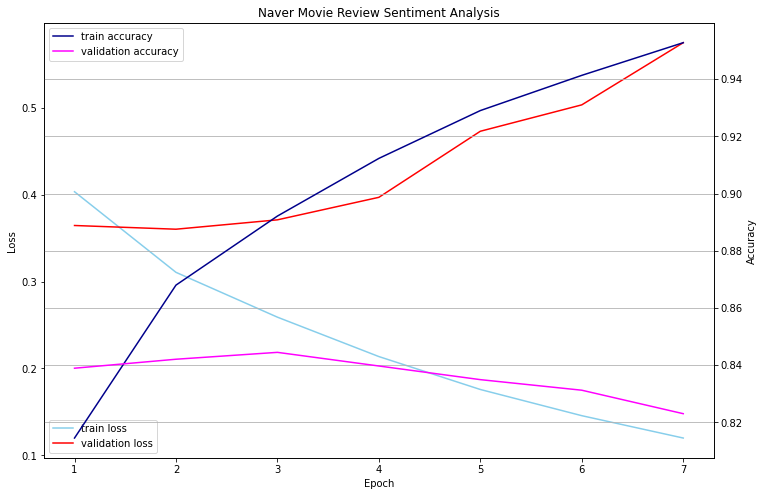

In [63]:
# X축은 공유
# y축의 좌측: loss, y축의 우측: accuracy
import matplotlib.pyplot as plt
fig, ax0 = plt.subplots(figsize=(12,8))
ax1 = ax0.twinx()
ax0.plot(xs, y_loss, c='skyblue', label='train loss')
ax0.plot(xs, y_vloss, c='red', label='validation loss')
ax0.set_ylabel('Loss')
ax0.set_xlabel('Epoch')

ax1.plot(xs, y_acc, c='darkblue', label='train accuracy')
ax1.plot(xs, y_vacc, c='magenta', label='validation accuracy')
ax1.set_ylabel('Accuracy')

ax0.legend(loc='best'), ax0.legend(loc='lower left'), ax1.legend()
plt.title('Naver Movie Review Sentiment Analysis')
plt.grid(); plt.show()

### 8. Conv1D + GRU

In [64]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GRU, Dropout

In [65]:
model2 = Sequential([
    Embedding(num_words, 120, input_length=max_len),
    Dropout(0.5),
    Conv1D(64, 5, activation='relu'),
    MaxPooling1D(5),
    GRU(128),
    Dense(1, activation='sigmoid')
])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 40, 120)           2400000   
                                                                 
 dropout (Dropout)           (None, 40, 120)           0         
                                                                 
 conv1d (Conv1D)             (None, 36, 64)            38464     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 7, 64)            0         
 )                                                               
                                                                 
 gru (GRU)                   (None, 128)               74496     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                      

In [67]:
model2.compile('adam', 'binary_crossentropy', ['accuracy'])
model2_path = 'best-naver-conv1d-gru.h5'
mc2 = ModelCheckpoint(model2_path, verbose=1, save_best_only=True)
es2 = EarlyStopping(patience=3)

In [68]:
hist2 = model2.fit(
    X_train, y_train, validation_split=0.2,
    epochs=30, batch_size=128, callbacks=[mc2,es2]
)
best_model2 = load_model(model2_path)
best_model2.evaluate(X_test, y_test)

Epoch 1/30
727/727 [==============================] - ETA: 0s - loss: 0.4617 - accuracy: 0.7689
Epoch 1: val_loss improved from inf to 0.40694, saving model to best-naver-conv1d-gru.h5
727/727 [==============================] - 71s 91ms/step - loss: 0.4617 - accuracy: 0.7689 - val_loss: 0.4069 - val_accuracy: 0.8086
Epoch 2/30
727/727 [==============================] - ETA: 0s - loss: 0.3653 - accuracy: 0.8339
Epoch 2: val_loss did not improve from 0.40694
727/727 [==============================] - 64s 88ms/step - loss: 0.3653 - accuracy: 0.8339 - val_loss: 0.4110 - val_accuracy: 0.8098
Epoch 3/30
727/727 [==============================] - ETA: 0s - loss: 0.3125 - accuracy: 0.8610
Epoch 3: val_loss did not improve from 0.40694
727/727 [==============================] - 63s 87ms/step - loss: 0.3125 - accuracy: 0.8610 - val_loss: 0.4273 - val_accuracy: 0.8066
Epoch 4/30
727/727 [==============================] - ETA: 0s - loss: 0.2695 - accuracy: 0.8820
Epoch 4: val_loss did not improve 

[0.40789633989334106, 0.8091750144958496]